In [1]:
import pandas as pd
import numpy as np
import re
import Levenshtein

Step 1: Import data

In [2]:
#import mine data
#primary data
mine_full = pd.read_excel("./Data/new coal/Global-Coal-Mine-Tracker-April-2024 (1).xlsx", sheet_name="Global Coal Mine Tracker (Non-C")
#supplement data
mine_sup1_full = pd.read_excel("./Data/new coal/Global-Coal-Mine-Tracker-September-2024-Supplement-v2 (2).xlsx", sheet_name="Historical Production (non-Chin")
mine_sup2_full =pd.read_excel("./Data/new coal/Global-Coal-Mine-Tracker-December-2024-Supplement-Historical-Production-from-2018-to-2023.xlsx", sheet_name="Historical Production(non-China")

In [3]:
#import plant data
plant_full = pd.read_excel("./Data/new coal/Global-Coal-Plant-Tracker-January-2025.xlsx", sheet_name="Units")

#correct the estimated capacity with capacity factor
plant_full['Est_capacity (MW)']=plant_full['Capacity (MW)']*plant_full['Capacity factor']

#import terminal data
#note: the capacity of terminal dataset may be overestimated, because some terminals not only receive 'coal' but 'all cargo'
terminal_full = pd.read_excel("./Data/new coal/Global-Coal-Terminals-Tracker-December-2024.xlsx", sheet_name="Terminals")

Step 2: Select only operating assets

In [4]:
#mine = mine_full[mine_full['Status'] == 'Operating']
plant = plant_full[plant_full['Status'] == 'operating']
terminal = terminal_full[terminal_full['Status'] == 'Operating']

Step 3: Only keep columns that we need

In [5]:
mine = mine_full[['GEM Mine ID', 'Mine Name', 'Latitude', 'Longitude', 'Country', 'Production (Mtpa)', 'Year of Production','Status','Parent Company']]
plant = plant[['GEM location ID', 'Plant name', 'Latitude', 'Longitude','Country/Area', 'Est_capacity (MW)', 'Parent']]
terminal = terminal[['GEM Terminal ID', 'Coal Terminal Name', 'Latitude', 'Longitude','Country/Area', 'Capacity (Mt)','Owner']] #there's only owner data in terminal dataset

In [6]:
# Rename the column names so they are consistent
mine.columns = ['asset_id', 'name', 'latitude', 'longitude', 'country', 'production', 'production year','status','firm']
plant.columns = ['asset_id', 'name', 'latitude', 'longitude', 'country', 'production', 'firm']
terminal.columns = ['asset_id', 'name', 'latitude', 'longitude', 'country', 'production', 'firm']

Step 4: Select Inida data

In [7]:
mine = mine[mine['country'] == 'India']
plant = plant[plant['country'] == 'India']
terminal = terminal[terminal['country'] == 'India']
mine_sup1 = mine_sup1_full[mine_sup1_full['Country'] == 'India']
mine_sup2 = mine_sup2_full[mine_sup2_full['Country'] == 'India']

Step 5: Select most recent production data for coal mine

In [8]:
# Combine 2 supplement dataset
mine_sup = pd.concat([mine_sup1, mine_sup2], ignore_index=True)
mine_sup.columns

Index(['GEM Mine ID', 'MSHA IDs', 'Country', 'Mine Name', 'Mine Name AKAs',
       'Mine Name (Non-ENG)', 'GEM Wiki Page (ENG)', 'Status',
       'Capacity (Mtpa)', 'Opening Year', 'ROM or Saleable',
       'Coal Output (Annual, Mt) 2023', 'Coal Output (Annual, Mst) 2023',
       'Output Accuracy', 'Coal Output (Annual, Mt) 2022',
       'Coal Output (Annual, Mst) 2022', 'Output Accuracy.1',
       'Coal Output (Annual, Mt) 2021', 'Coal Output (Annual, Mst) 2021',
       'Output Accuracy.2', 'Coal Output (Annual, Mt) 2020',
       'Coal Output (Annual, Mst) 2020', 'Output Accuracy.3',
       'Coal Output (Annual, Mt) 2019', 'Coal Output (Annual, Mst) 2019',
       'Output Accuracy.4', 'Coal Output (Annual, Mt) 2018',
       'Coal Output (Annual, Mst) 2018', 'Output Accuracy.5',
       'Coal Output (Annual, Mt) 2017', 'Coal Output (Annual, Mst) 2017',
       'Output Accuracy.6'],
      dtype='object')

In [9]:
# Replace '-' with NaN
mine_sup.replace('-', pd.NA, inplace=True)
# Generate column names for 'Coal Output (Annual, Mt)' from 2023 to 2017
years = list(range(2023, 2016, -1))  # List of years from 2023 to 2017
cols = [f"Coal Output (Annual, Mt) {year}" for year in years]

# Select the most recent non-null coal output value
mine_sup["Most_Recent_Coal_Output_Mt"] = mine_sup[cols].bfill(axis=1).iloc[:, 0]

# Identify the corresponding year for the selected coal output
mine_sup["Year_Selected"] = mine_sup[cols].notna().idxmax(axis=1).str.extract(r'(\d{4})')

# Convert 'Year_Selected' to integer
mine_sup["Year_Selected"] = mine_sup["Year_Selected"].astype("Int64")

In [10]:
# Keep necessary columns and rename columns
mine_sup = mine_sup[['GEM Mine ID','Most_Recent_Coal_Output_Mt','Year_Selected']]
mine_sup.columns = ['asset_id', 'production', 'production year']
mine_sup['status'] = 'Operating' # all the assets in supplement data have Operating status
mine_sup

,asset_id,production,production year,status
0,M4434,4,2023,Operating
1,M2697,3.91,2023,Operating
2,M2513,2.17,2023,Operating
3,M1722,1.32,2023,Operating
4,M0573,2.531,2022,Operating
...,...,...,...,...
348,M2859,0.32,2023,Operating
349,M6680,0.028,2023,Operating
350,M2718,0.04,2022,Operating
351,M1746,0.36,2023,Operating


In [11]:
# Merge supplement data with mine data
# Step 1: Merge mine_sup onto mine, allowing multiple production records per mine
merged = pd.concat([mine, mine_sup], ignore_index=True)

# Step 2: Sort by asset_id and production year (descending) to get the most recent data
merged = merged.sort_values(by=['asset_id', 'production year'], ascending=[True, False])

# Step 3: Group by asset_id and take the first occurrence (most recent)
mine_merged = merged.groupby('asset_id', as_index=False).first()

In [12]:
mine_merged

,asset_id,name,latitude,longitude,country,production,production year,status,firm
0,M0464,Adasa Coal Mine,21.347003,78.953545,India,0.715,2023,Operating,Coal India Ltd [100.0%]
1,M0465,Adriyala Coal Mine,18.6648,79.579,India,1.7,2023,Operating,The Singareni Collieries Co Ltd [100%]
2,M0466,AKK Coal Mine,23.7905,85.9198,India,5.35,2023,Operating,Coal India Ltd [100.0%]
3,M0467,Amadand Coal Mine,23.157942,82.061533,India,3.32,2023,Operating,Coal India Ltd [100.0%]
4,M0468,Amalgamated Keshalpur-West Mudidih (AKWMC) Coa...,23.8078,86.3221,India,3.14,2023,Operating,Coal India Ltd [100.0%]
...,...,...,...,...,...,...,...,...,...
510,M4466,Utkal E Coal Mine,21.086237,84.872237,India,2,2023,Operating,National Aluminium Co Ltd [100%]
511,M4467,Venkatesh Khani Coal mine,17.47979,80.663705,India,*,None,Proposed,The Singareni Collieries Co Ltd [100%]
512,M4468,Bicharpur Coal Mine,23.265914,81.343859,India,0.75,2023,Operating,Aditya Birla Group
513,M6680,None,None,None,None,0.028,2023,Operating,None


In [13]:
# Filler Operating assets only
mine_merged = mine_merged[mine_merged['status'] == 'Operating']
mine_merged

,asset_id,name,latitude,longitude,country,production,production year,status,firm
0,M0464,Adasa Coal Mine,21.347003,78.953545,India,0.715,2023,Operating,Coal India Ltd [100.0%]
1,M0465,Adriyala Coal Mine,18.6648,79.579,India,1.7,2023,Operating,The Singareni Collieries Co Ltd [100%]
2,M0466,AKK Coal Mine,23.7905,85.9198,India,5.35,2023,Operating,Coal India Ltd [100.0%]
3,M0467,Amadand Coal Mine,23.157942,82.061533,India,3.32,2023,Operating,Coal India Ltd [100.0%]
4,M0468,Amalgamated Keshalpur-West Mudidih (AKWMC) Coa...,23.8078,86.3221,India,3.14,2023,Operating,Coal India Ltd [100.0%]
...,...,...,...,...,...,...,...,...,...
507,M4463,Prakasham Khani OC Coal Mine,17.943213,80.77821,India,5.27,2023,Operating,The Singareni Collieries Co Ltd [100%]
510,M4466,Utkal E Coal Mine,21.086237,84.872237,India,2,2023,Operating,National Aluminium Co Ltd [100%]
512,M4468,Bicharpur Coal Mine,23.265914,81.343859,India,0.75,2023,Operating,Aditya Birla Group
513,M6680,None,None,None,None,0.028,2023,Operating,None


In [14]:
# Replace '*' with NaN
mine_merged.replace('*', pd.NA, inplace=True)
# Drop rows with NA
mine_merged = mine_merged.dropna()
# Drop columns are not needed
mine_final = mine_merged[['asset_id', 'name', 'latitude', 'longitude', 'country', 'production', 'firm']]

/var/folders/3h/83jfd71114x78b1sj0_llf1m0000gp/T/ipykernel_54038/3752152700.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mine_merged.replace('*', pd.NA, inplace=True)


In [15]:
mine_final

,asset_id,name,latitude,longitude,country,production,firm
0,M0464,Adasa Coal Mine,21.347003,78.953545,India,0.715,Coal India Ltd [100.0%]
1,M0465,Adriyala Coal Mine,18.664800,79.579000,India,1.7,The Singareni Collieries Co Ltd [100%]
2,M0466,AKK Coal Mine,23.790500,85.919800,India,5.35,Coal India Ltd [100.0%]
3,M0467,Amadand Coal Mine,23.157942,82.061533,India,3.32,Coal India Ltd [100.0%]
4,M0468,Amalgamated Keshalpur-West Mudidih (AKWMC) Coa...,23.807800,86.322100,India,3.14,Coal India Ltd [100.0%]
...,...,...,...,...,...,...,...
502,M4458,Pandaveswar Dalurband Coal Mine,23.697576,87.253978,India,1.08,Coal India Ltd [100.0%]
503,M4459,Parasea Belbaid Coal Mine,23.604032,87.114406,India,0.07,Coal India Ltd [100.0%]
507,M4463,Prakasham Khani OC Coal Mine,17.943213,80.778210,India,5.27,The Singareni Collieries Co Ltd [100%]
510,M4466,Utkal E Coal Mine,21.086237,84.872237,India,2,National Aluminium Co Ltd [100%]


Step 6: Combine all types of assets

In [134]:
total_data = pd.concat([mine_final, plant, terminal], ignore_index=True)

In [135]:
total_data

,asset_id,name,latitude,longitude,country,production,firm
0,M0464,Adasa Coal Mine,21.347003,78.953545,India,0.715,Coal India Ltd [100.0%]
1,M0465,Adriyala Coal Mine,18.6648,79.579,India,1.7,The Singareni Collieries Co Ltd [100%]
2,M0466,AKK Coal Mine,23.7905,85.9198,India,5.35,Coal India Ltd [100.0%]
3,M0467,Amadand Coal Mine,23.157942,82.061533,India,3.32,Coal India Ltd [100.0%]
4,M0468,Amalgamated Keshalpur-West Mudidih (AKWMC) Coa...,23.8078,86.3221,India,3.14,Coal India Ltd [100.0%]
...,...,...,...,...,...,...,...
1233,T1164,Sikka Port Coal Terminal,22.433723,69.820199,India,3,Shree Cement
1234,T1017,Trombay Coal Terminal,18.991606,72.908227,India,2.4,Tata Group
1235,T1165,Tuna Tekra Port Coal Terminal,22.907645,70.104361,India,20,Adani Group
1236,T1058,Tuticorin Port Coal Terminal,8.756765,78.212002,India,29,V.O. Chidambaranar Port Trust


In [18]:
with pd.ExcelWriter('./Data/total_data.xlsx') as writer:
    total_data.to_excel(writer, index=False)

## Sheet 1: Assets

In [136]:
# Add the 'product' column based on 'asset_id'
total_data["product"] = total_data["asset_id"].apply(
    lambda x: "coal" if str(x).startswith(("M", "T")) else "power" if str(x).startswith("L") else None
)

In [137]:
total_data

,asset_id,name,latitude,longitude,country,production,firm,product
0,M0464,Adasa Coal Mine,21.347003,78.953545,India,0.715,Coal India Ltd [100.0%],coal
1,M0465,Adriyala Coal Mine,18.6648,79.579,India,1.7,The Singareni Collieries Co Ltd [100%],coal
2,M0466,AKK Coal Mine,23.7905,85.9198,India,5.35,Coal India Ltd [100.0%],coal
3,M0467,Amadand Coal Mine,23.157942,82.061533,India,3.32,Coal India Ltd [100.0%],coal
4,M0468,Amalgamated Keshalpur-West Mudidih (AKWMC) Coa...,23.8078,86.3221,India,3.14,Coal India Ltd [100.0%],coal
...,...,...,...,...,...,...,...,...
1233,T1164,Sikka Port Coal Terminal,22.433723,69.820199,India,3,Shree Cement,coal
1234,T1017,Trombay Coal Terminal,18.991606,72.908227,India,2.4,Tata Group,coal
1235,T1165,Tuna Tekra Port Coal Terminal,22.907645,70.104361,India,20,Adani Group,coal
1236,T1058,Tuticorin Port Coal Terminal,8.756765,78.212002,India,29,V.O. Chidambaranar Port Trust,coal


Before grouping all the columns, we first check if each asset has more than one unique value in the 'firm' column.

In [138]:
# Group by 'asset_id' and count unique 'firm' values
df_grouped = total_data.groupby('asset_id')['firm'].nunique()

# Filter for asset_ids with more than 1 unique firm
assets_with_multiple_firms = df_grouped[df_grouped > 1].index

# Display rows where asset_id has more than 1 unique firm
df_filtered = total_data[total_data['asset_id'].isin(assets_with_multiple_firms)]
df_filtered

,asset_id,name,latitude,longitude,country,production,firm,product
902,L100000102487,Paradip power station,20.31221,86.645829,India,16.5,unknown [19.0%]; Essar Energy Ltd; Triton Trus...,power
903,L100000102487,Paradip power station,20.31221,86.645829,India,16.5,unknown [19.0%]; Essar Energy Ltd; Triton Trus...,power
904,L100000102487,Paradip power station,20.31221,86.645829,India,16.5,ArcelorMittal SA [60.0%]; Nippon Steel Corp [4...,power
905,L100000102487,Paradip power station,20.31221,86.645829,India,16.5,ArcelorMittal SA [60.0%]; Nippon Steel Corp [4...,power


In [139]:
# Aggregate firm information for L100000102487 manually
total_data.loc[total_data['asset_id'] == 'L100000102487', 'firm'] = 'unknown [9.5%]; Essar Energy Ltd; Triton Trust; Virgo Trust; ArcelorMittal SA [30.0%]; Nippon Steel Corp [20.0%]'

In [140]:
# Group by 'asset_id' and apply aggregation
total_data_grouped = total_data.groupby("asset_id", as_index=False).agg({
    "name": "first",
    "latitude": "first",
    "longitude": "first",
    "country": "first",
    "production": "sum",
    "firm": "first",
    "product": "first"
})

In [141]:
total_data_grouped

,asset_id,name,latitude,longitude,country,production,firm,product
0,L100000102032,Balaji Cement power station,16.283333,81.216667,India,19.25,Jaiprakash Associates Ltd [100.0%],power
1,L100000102033,Bander power station,14.351195,80.143086,India,726.0,Tanweer Infrastructure SAOC,power
2,L100000102038,Dr. Narla Tata Rao Thermal power station,16.59849,80.536585,India,1408.0,Andhra Pradesh Power Generation Corp Ltd [100.0%],power
3,L100000102040,East Godavari Mill power station,17.300117,82.614386,India,18.7,Andhra Paper Ltd [100.0%],power
4,L100000102052,Makavarapalem Smelter power station,17.466444,82.961361,India,49.5,Penna Group; Ras Al Khaimah Investment Authority,power
...,...,...,...,...,...,...,...,...
667,T1179,Kolkata Dock System Coal Terminal,22.532577,88.3111,India,3,Kolkata Port Trust,coal
668,T1180,Bedi Port Coal Terminal,22.515273,70.029323,India,6,Gujarat Maritime Board,coal
669,T1181,Haldia Port Coal Terminal,22.037654,88.091404,India,20,Government of India,coal
670,T1182,Karaikal Port Coal Terminal,10.84241,79.843483,India,20,-,coal


In [142]:
# Exclude the firm column
total_assets = total_data_grouped.drop(columns=['firm'])

In [143]:
total_assets

,asset_id,name,latitude,longitude,country,production,product
0,L100000102032,Balaji Cement power station,16.283333,81.216667,India,19.25,power
1,L100000102033,Bander power station,14.351195,80.143086,India,726.0,power
2,L100000102038,Dr. Narla Tata Rao Thermal power station,16.59849,80.536585,India,1408.0,power
3,L100000102040,East Godavari Mill power station,17.300117,82.614386,India,18.7,power
4,L100000102052,Makavarapalem Smelter power station,17.466444,82.961361,India,49.5,power
...,...,...,...,...,...,...,...
667,T1179,Kolkata Dock System Coal Terminal,22.532577,88.3111,India,3,coal
668,T1180,Bedi Port Coal Terminal,22.515273,70.029323,India,6,coal
669,T1181,Haldia Port Coal Terminal,22.037654,88.091404,India,20,coal
670,T1182,Karaikal Port Coal Terminal,10.84241,79.843483,India,20,coal


In [144]:
# Add a new replacement_value column with NA
prod_index = total_assets.columns.get_loc('production')
total_assets.insert(prod_index, 'replacement_value', pd.NA)

In [29]:
import plotly.express as px

In [30]:
# Define color mapping for asset_id prefixes
df_india = total_assets.copy()

color_mapping = {
    "M": "red",
    "L": "blue",
    "T": "green"
}

# Assign colors based on asset_id prefix
df_india["color"] = df_india["asset_id"].str[0].map(color_mapping).fillna("gray")

# Create Plotly scatter mapbox
fig = px.scatter_mapbox(
    df_india,
    lat="latitude",
    lon="longitude",
    text="name",
    color="color",  # Assign color
    size=[0.01] * len(df_india),  # Control marker size
    title="Indian Coal Assets Distribution",
    zoom=3,
    height=700
)

# Set the Mapbox token (replace with your own Mapbox token if needed)
fig.update_layout(
    mapbox_style="carto-positron",
    mapbox_center={"lat": 22.3511, "lon": 78.6677},
    margin={"r": 0, "t": 50, "l": 0, "b": 0}
)

# Show figure
fig.show()

In [26]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

/var/folders/3h/83jfd71114x78b1sj0_llf1m0000gp/T/ipykernel_54038/1499974731.py:10: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


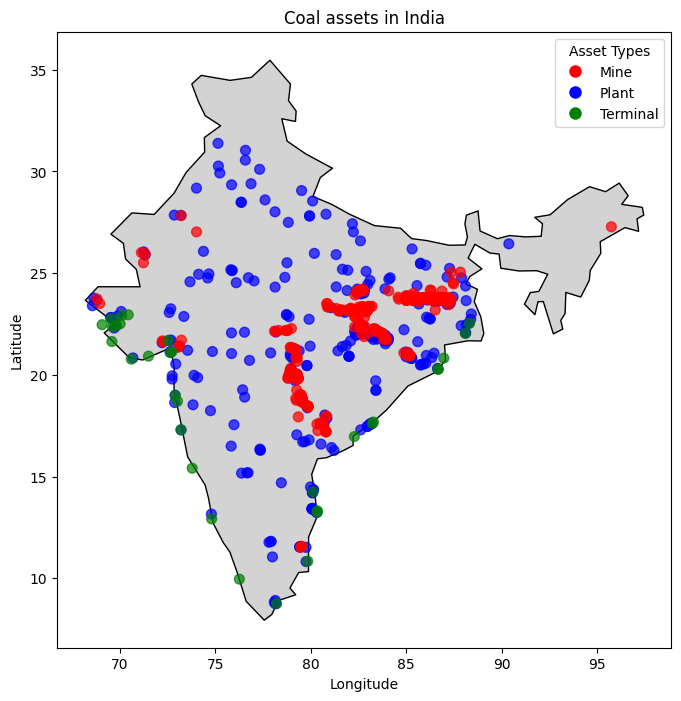

In [27]:
# Create GeoDataFrame with asset locations
gdf = gpd.GeoDataFrame(total_assets, 
                       geometry=gpd.points_from_xy(total_assets.longitude, total_assets.latitude),
                       crs="EPSG:4326")  # WGS 84 Coordinate System

# Add a new column for the color based on asset_id
gdf['color'] = gdf['asset_id'].apply(lambda x: 'red' if x.startswith('M') else ('blue' if x.startswith('L') else 'green'))

# Load world map data
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Filter to get only India
india = world[world.name == "India"]

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 8))

# Plot India's map
india.plot(ax=ax, color='lightgrey', edgecolor='black')

# Plot the mine locations with different colors
gdf.plot(ax=ax, color=gdf['color'], markersize=50, alpha=0.7)

# Create custom legend
legend_labels = {
    'Mine': 'red',
    'Plant': 'blue',
    'Terminal': 'green'
}

# Create legend handles for custom legend
handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in legend_labels.values()]

# Add custom legend to the plot
plt.legend(handles=handles, labels=legend_labels.keys(), title="Asset Types")

# Add labels and title
plt.title("Coal assets in India")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


## Sheet 2 & 3: Firms & Ownership

In [145]:
total_data_grouped

,asset_id,name,latitude,longitude,country,production,firm,product
0,L100000102032,Balaji Cement power station,16.283333,81.216667,India,19.25,Jaiprakash Associates Ltd [100.0%],power
1,L100000102033,Bander power station,14.351195,80.143086,India,726.0,Tanweer Infrastructure SAOC,power
2,L100000102038,Dr. Narla Tata Rao Thermal power station,16.59849,80.536585,India,1408.0,Andhra Pradesh Power Generation Corp Ltd [100.0%],power
3,L100000102040,East Godavari Mill power station,17.300117,82.614386,India,18.7,Andhra Paper Ltd [100.0%],power
4,L100000102052,Makavarapalem Smelter power station,17.466444,82.961361,India,49.5,Penna Group; Ras Al Khaimah Investment Authority,power
...,...,...,...,...,...,...,...,...
667,T1179,Kolkata Dock System Coal Terminal,22.532577,88.3111,India,3,Kolkata Port Trust,coal
668,T1180,Bedi Port Coal Terminal,22.515273,70.029323,India,6,Gujarat Maritime Board,coal
669,T1181,Haldia Port Coal Terminal,22.037654,88.091404,India,20,Government of India,coal
670,T1182,Karaikal Port Coal Terminal,10.84241,79.843483,India,20,-,coal


In [146]:
# Keep necessary columns
all_firms = total_data_grouped[['asset_id','name','firm']]

In [147]:
all_firms

,asset_id,name,firm
0,L100000102032,Balaji Cement power station,Jaiprakash Associates Ltd [100.0%]
1,L100000102033,Bander power station,Tanweer Infrastructure SAOC
2,L100000102038,Dr. Narla Tata Rao Thermal power station,Andhra Pradesh Power Generation Corp Ltd [100.0%]
3,L100000102040,East Godavari Mill power station,Andhra Paper Ltd [100.0%]
4,L100000102052,Makavarapalem Smelter power station,Penna Group; Ras Al Khaimah Investment Authority
...,...,...,...
667,T1179,Kolkata Dock System Coal Terminal,Kolkata Port Trust
668,T1180,Bedi Port Coal Terminal,Gujarat Maritime Board
669,T1181,Haldia Port Coal Terminal,Government of India
670,T1182,Karaikal Port Coal Terminal,-


In [148]:
# Check NAs and add firm info manually
invalid_rows = all_firms[all_firms['firm'] == '-']
invalid_rows

,asset_id,name,firm
670,T1182,Karaikal Port Coal Terminal,-


In [149]:
# From website https://en.wikipedia.org/wiki/Karaikal_Port, we know that APSEZ holds 100% share of Karaikal Port Coal Terminal
# Update the 'firm' value for asset_id T1182
all_firms.loc[all_firms['asset_id'] == 'T1182', 'firm'] = 'Adani Ports and Special Economic Zone Limited'

In [150]:
all_firms

,asset_id,name,firm
0,L100000102032,Balaji Cement power station,Jaiprakash Associates Ltd [100.0%]
1,L100000102033,Bander power station,Tanweer Infrastructure SAOC
2,L100000102038,Dr. Narla Tata Rao Thermal power station,Andhra Pradesh Power Generation Corp Ltd [100.0%]
3,L100000102040,East Godavari Mill power station,Andhra Paper Ltd [100.0%]
4,L100000102052,Makavarapalem Smelter power station,Penna Group; Ras Al Khaimah Investment Authority
...,...,...,...
667,T1179,Kolkata Dock System Coal Terminal,Kolkata Port Trust
668,T1180,Bedi Port Coal Terminal,Gujarat Maritime Board
669,T1181,Haldia Port Coal Terminal,Government of India
670,T1182,Karaikal Port Coal Terminal,Adani Ports and Special Economic Zone Limited


## Format firm names and extract share data

### Step 1: Seperate rows with multiple firms into different rows

In [151]:
def process_firm_name(df):
    # Step 1: Count the maximum number of delimiters (either ';' or ',')
    max_delimiters = df['firm'].str.count(r'[;,]').max()
    
    # Dynamically create column names based on the max delimiter count
    name_columns = [f'name{i+1}' for i in range(max_delimiters + 1)]

    # Split the 'firm' column by ';' or ',' into separate columns
    df[name_columns] = df['firm'].str.split(r'[;,]', expand=True, n=max_delimiters)

    # Step 2: Duplicate all other columns for each new entry
    df_expanded = df.drop(columns=['firm'])  # Drop the original 'firm' column

    # Step 3: Melt the dynamically created name columns
    df_flat = pd.melt(df_expanded, id_vars=['asset_id'], 
                      value_vars=name_columns, value_name='firm')

    # Step 4: Remove rows with NaN values in 'firm'
    df_flat = df_flat.dropna(subset=['firm'])

    # Step 5: Move 'firm' to the second column position
    df_flat.insert(1, 'firm', df_flat.pop('firm'))

    # Reset index for clean output
    df_flat.reset_index(drop=True, inplace=True)

    # Drop 'variable' column
    df_flat = df_flat.drop(columns=['variable'])

    return df_flat

# Apply the function
all_firms_flat = process_firm_name(all_firms)

/var/folders/3h/83jfd71114x78b1sj0_llf1m0000gp/T/ipykernel_54038/1224347009.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[name_columns] = df['firm'].str.split(r'[;,]', expand=True, n=max_delimiters)
/var/folders/3h/83jfd71114x78b1sj0_llf1m0000gp/T/ipykernel_54038/1224347009.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[name_columns] = df['firm'].str.split(r'[;,]', expand=True, n=max_delimiters)
/var/folders/3h/83jfd71114x78b1sj0_llf1m0000gp/T/ipykernel_54038/1224347009.py:9: SettingWithCop

In [152]:
all_firms_flat

,asset_id,firm
0,L100000102032,Jaiprakash Associates Ltd [100.0%]
1,L100000102033,Tanweer Infrastructure SAOC
2,L100000102038,Andhra Pradesh Power Generation Corp Ltd [100.0%]
3,L100000102040,Andhra Paper Ltd [100.0%]
4,L100000102052,Penna Group
...,...,...
735,L100001000101,natural person(s) [0.0%]
736,L100000102487,Nippon Steel Corp [20.0%]
737,L100000102542,Housing Development Finance Corp Ltd [9.0%]
738,L100000102542,Central Bank of India [7.7%]


In [62]:
with pd.ExcelWriter('./Data/all_firms_flat.xlsx') as writer:
    all_firms_flat.to_excel(writer, index=False)

### Step 2: Extract the share data

In [175]:
def extract_percentage(firm):
    match = re.search(r'[\[\(](\d+(\.\d+)?%)[]\)]', firm)
    return match.group(1) if match else pd.NA

# Apply the function to create the new column
all_firms_flat['share'] = all_firms_flat['firm'].apply(extract_percentage)
all_firms_flat

,asset_id,firm,share
0,L100000102032,Jaiprakash Associates Ltd [100.0%],100.0%
1,L100000102033,Tanweer Infrastructure SAOC,<NA>
2,L100000102038,Andhra Pradesh Power Generation Corp Ltd [100.0%],100.0%
3,L100000102040,Andhra Paper Ltd [100.0%],100.0%
4,L100000102052,Penna Group,<NA>
...,...,...,...
735,L100001000101,natural person(s) [0.0%],0.0%
736,L100000102487,Nippon Steel Corp [20.0%],20.0%
737,L100000102542,Housing Development Finance Corp Ltd [9.0%],9.0%
738,L100000102542,Central Bank of India [7.7%],7.7%


In [176]:
# Check NAs in share
missing_share = all_firms_flat[all_firms_flat['share'].isna()]
missing_share

,asset_id,firm,share
1,L100000102033,Tanweer Infrastructure SAOC,NaN
4,L100000102052,Penna Group,NaN
6,L100000102055,Tanweer Infrastructure SAOC,NaN
13,L100000102079,Sarda Energy & Minerals Ltd,NaN
16,L100000102083,Hinduja Group Ltd,NaN
...,...,...,...
725,L100000102563,Megha Engineering & Infrastructures Ltd,NaN
727,L100000102210,Virgo Trust,NaN
728,L100000102224,Virgo Trust,NaN
729,L100000102275,Sunrwoth Stocks Pvt Ltd,NaN


For assets with completely missing share data, we assign an equal share to each. For assets with partially missing share data, we distribute the remaining share equally among the incomplete entries.

In [177]:
# Convert share to numeric (for easier calculation), replacing any '%' sign and converting to float
all_firms_flat['share'] = all_firms_flat['share'].apply(lambda x: float(str(x).replace('%', '')) if pd.notna(x) else pd.NA)

# Function to calculate the share for each asset_id with partially missing shares
def calculate_share(group):
    # Find the rows with non-missing share values
    missing_share_rows = group[group['share'].isna()]
    
    if len(missing_share_rows) > 0:
        # Calculate the remaining share to distribute (100% - known share)
        total_known_share = group['share'].sum()  # Sum of known shares
        remaining_share = 100 - total_known_share
        
        # Distribute the remaining share equally among the missing rows
        share_per_missing = remaining_share / len(missing_share_rows)
        
        # Assign the calculated share to the missing rows
        group.loc[group['share'].isna(), 'share'] = share_per_missing
    
    return group

# Group by asset_id and apply the share calculation
df = all_firms_flat.groupby('asset_id').apply(calculate_share)

# Convert share back to percentage format
df['share'] = df['share'].apply(lambda x: f"{x}%")


In [178]:
# Resetting the index to make 'asset_id' a regular column
df = df.reset_index(drop=True)
df

,asset_id,firm,share
0,L100000102032,Jaiprakash Associates Ltd [100.0%],100.0%
1,L100000102033,Tanweer Infrastructure SAOC,100.0%
2,L100000102038,Andhra Pradesh Power Generation Corp Ltd [100.0%],100.0%
3,L100000102040,Andhra Paper Ltd [100.0%],100.0%
4,L100000102052,Penna Group,50.0%
...,...,...,...
735,T1179,Kolkata Port Trust,100.0%
736,T1180,Gujarat Maritime Board,100.0%
737,T1181,Government of India,100.0%
738,T1182,Adani Ports and Special Economic Zone Limited,100.0%


### Step 3: Format firm names

In [179]:
def clean_firm_names(df):
    # Remove percentage patterns inside square brackets or parentheses
    df['firm'] = df['firm'].str.replace(r'\[\d+(\.\d+)?%\]', '', regex=True)  # Remove percentage in brackets
    df['firm'] = df['firm'].str.replace(r'\(\d+(\.\d+)?%\)', '', regex=True)  # Remove percentage in parentheses
    
    # Remove the abbreviations (capital letters inside parentheses)
    df['firm'] = df['firm'].str.replace(r'\(([A-Z]+)\)', '', regex=True)  # Remove all capital letters inside parentheses
    
    # Remove a dot at the end of the name (if it exists)
    df['firm'] = df['firm'].str.replace(r'\.$', '', regex=True)
    
    # Strip any leading or trailing spaces
    df['firm'] = df['firm'].str.strip()
    
    return df

In [180]:
df = clean_firm_names(df)

In [181]:
# Function to standardize company names
def standardize_company_name(name):
    # Remove "Ltd" and "Limited"
    name = re.sub(r'\bLtd\b', '', name, flags=re.IGNORECASE)
    name = re.sub(r'\bLimited\b', '', name, flags=re.IGNORECASE)
    
    # Replace "Co" with "Company"
    name = re.sub(r'\bCo\b', 'Company', name)
    
    # Replace "Corp" with "Corporation"
    name = re.sub(r'\bCorp\b', 'Corporation', name)
    
    # Remove duplicate "Company Company"
    #name = re.sub(r'\bCompany\b\s*\bCompany\b', 'Company', name)
    
    # Remove any extra spaces
    name = name.strip()
    
    return name

# Apply the function to the 'Company Name' column
df['firm'] = df['firm'].apply(standardize_company_name)

In [162]:
with pd.ExcelWriter('./Data/df2.xlsx') as writer:
    df.to_excel(writer, index=False)

In [182]:
# Function to find pairs of names with less than 3 letters difference
def find_similar_names(df):
    names = df['firm'].tolist()  # Get list of names
    similar_names = []

    # Compare each pair of names
    for i in range(len(names)):
        for j in range(i + 1, len(names)):
            # Calculate the Levenshtein distance between the two names
            distance = Levenshtein.distance(names[i], names[j])
            # If the distance is less than 3, consider it similar
            if distance < 5 and distance > 0:
                similar_names.append((names[i], names[j], distance))

    return similar_names

# Find similar names with less than 3 letters difference
similar_names = find_similar_names(df)

# Print the results
for name1, name2, dist in similar_names:
    print(f"'{name1}' & '{name2}':  have a Levenshtein distance of {dist}")

'Penna Group' & 'Hira Group':  have a Levenshtein distance of 4
'Penna Group' & 'Gupta Group':  have a Levenshtein distance of 4
'Penna Group' & 'Tata Group':  have a Levenshtein distance of 4
'Penna Group' & 'Adani Group':  have a Levenshtein distance of 4
'Penna Group' & 'Adani Group':  have a Levenshtein distance of 4
'Penna Group' & 'Adani Group':  have a Levenshtein distance of 4
'Penna Group' & 'Adani Group':  have a Levenshtein distance of 4
'Penna Group' & 'Adani Group':  have a Levenshtein distance of 4
'Penna Group' & 'Adani Group':  have a Levenshtein distance of 4
'Vedanta' & 'Vedanta Inc':  have a Levenshtein distance of 4
'Vedanta' & 'Vedanta Inc':  have a Levenshtein distance of 4
'Vedanta' & 'Vedanta Inc':  have a Levenshtein distance of 4
'Vedanta' & 'Vedanta Inc':  have a Levenshtein distance of 4
'Vedanta' & 'Vedanta Inc':  have a Levenshtein distance of 4
'NTPC' & 'ISMT':  have a Levenshtein distance of 4
'NTPC' & 'CESC':  have a Levenshtein distance of 3
'NTPC' & '

In [167]:
!pip install fuzzywuzzy

    extract-msg (<=0.29.*)
                 ~~~~~~~^

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [186]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

# Function to find similar names with fuzzywuzzy
def find_similar_names(df, threshold=85):
    names = df['firm'].tolist()  # Get list of names
    similar_names = []

    # Compare each pair of names using fuzzywuzzy
    for i in range(len(names)):
        for j in range(i + 1, len(names)):
            score = fuzz.ratio(names[i].lower(), names[j].lower())  # Case-insensitive comparison
            if score >= threshold and score != 100:  # Only show pairs where the score is not 100
                similar_names.append((names[i], names[j], score))

    return similar_names

# Find similar names with a threshold score (e.g., 90% similarity)
similar_names = find_similar_names(df)

# Print the results
for name1, name2, score in similar_names:
    print(f"'{name1}' & '{name2}': have a similarity score of {score}")


'Rajasthan State Mines and Minerals' & 'Rajasthan State Mines & Minerals': have a similarity score of 94
'Rajasthan State Mines and Minerals' & 'Rajasthan State Mines & Minerals': have a similarity score of 94


In [32]:
# Add more columns that will be needed
def add_firms_columns(df, owner_column, firm_type):

    firms = df[[owner_column]].rename(columns={owner_column: 'name'})
    
    # Adding columns
    firms['firm_id'] = pd.NA
    firms['final_demand'] = pd.NA
    firms['discount_rate'] = pd.NA
    firms['unit_price'] = pd.NA
    firms['margin'] = pd.NA
    firms['leverage_ratio'] = pd.NA
    firms['type'] = firm_type
    
    # Adjust order of columns
    firms = firms[['firm_id', 'name', 'final_demand', 'discount_rate', 
                   'unit_price', 'margin', 'leverage_ratio', 'type']]
    
    return firms

# Apply functions
total_firms = add_firms_columns(all_firms, 'firm', 'production')

# Remove duplicates
total_firms.drop_duplicates(subset=['name'], keep='first', inplace=True)

In [33]:
total_firms # 324 rows

,firm_id,name,final_demand,discount_rate,unit_price,margin,leverage_ratio,type
0,NaN,Jaiprakash Associates Ltd [100.0%],NaN,NaN,NaN,NaN,NaN,production
1,NaN,Tanweer Infrastructure SAOC,NaN,NaN,NaN,NaN,NaN,production
2,NaN,Andhra Pradesh Power Generation Corp Ltd [100.0%],NaN,NaN,NaN,NaN,NaN,production
3,NaN,Andhra Paper Ltd [100.0%],NaN,NaN,NaN,NaN,NaN,production
4,NaN,Penna Group; Ras Al Khaimah Investment Authority,NaN,NaN,NaN,NaN,NaN,production
...,...,...,...,...,...,...,...,...
666,NaN,Gangavaram Port Ltd.,NaN,NaN,NaN,NaN,NaN,production
667,NaN,Kolkata Port Trust,NaN,NaN,NaN,NaN,NaN,production
669,NaN,Government of India,NaN,NaN,NaN,NaN,NaN,production
670,NaN,-,NaN,NaN,NaN,NaN,NaN,production


For some datasets, the shares of firms are indicated in the owner names, so we need to separate the firm names

In [20]:
# Filter rows where 'name' contains '['
filtered_df = total_firms[total_firms['name'].str.contains(r'\(', regex=True)]

# Display the filtered rows
filtered_df

,firm_id,name,final_demand,discount_rate,unit_price,margin,leverage_ratio,type
544,NaN,Anuppur Thermal Energy (MP) Pvt Ltd [100%],NaN,NaN,NaN,NaN,NaN,production
601,NaN,MB Power (Madhya Pradesh) Ltd [100%],NaN,NaN,NaN,NaN,NaN,production
733,NaN,ACB (India) Ltd [100%],NaN,NaN,NaN,NaN,NaN,production
957,NaN,Ind-Barath Energy (Utkal) Ltd [100%],NaN,NaN,NaN,NaN,NaN,production
1194,NaN,Mirzapur Thermal Energy (UP) Pvt Ltd [100%],NaN,NaN,NaN,NaN,NaN,production
1196,NaN,Pench Thermal Energy (MP) Ltd [100%],NaN,NaN,NaN,NaN,NaN,production
1313,NaN,Aditya Birla Chemicals (India) Ltd [100%],NaN,NaN,NaN,NaN,NaN,production
1742,NaN,Mumbai Port Trust (MbPT),NaN,NaN,NaN,NaN,NaN,production
1745,NaN,Essar Group (74%); AM/NS (26%),NaN,NaN,NaN,NaN,NaN,production
1765,NaN,Mormugao Port Trust (MPT),NaN,NaN,NaN,NaN,NaN,production


## Format firm names

In [21]:
def process_firm_name(df):
    
    # Step 1: Split the 'name' column by ';' into two separate columns
    df[['name1', 'name2','name3']] = df['name'].str.split(r'[;,]', expand=True)

    # Step 2: Duplicate all other columns for each new entry
    df_expanded = df.drop(columns=['name'])  # Drop the original 'name' column

    # Step 3: Melt the 'name1' and 'name2' columns
    df_flat = pd.melt(df_expanded, id_vars=['firm_id', 'final_demand', 'discount_rate', 'unit_price', 'margin', 'leverage_ratio', 'type'], 
                      value_vars=['name1', 'name2','name3'], value_name='name')

    # Step 4: Remove rows with NaN values in 'name'
    df_flat = df_flat.dropna(subset=['name'])

    # Step 5: Move 'name' to the second column position
    df_flat.insert(1, 'name', df_flat.pop('name'))

    # Reset index for clean output
    df_flat.reset_index(drop=True, inplace=True)

    # Drop 'variable' column
    df_flat = df_flat.drop(columns=['variable'])

    return df_flat

# Apply the function
total_firms_flat = process_firm_name(total_firms)

In [22]:
# Display the result
total_firms_flat # 343 rows

,firm_id,name,final_demand,discount_rate,unit_price,margin,leverage_ratio,type
0,NaN,Western Coalfields Ltd,NaN,NaN,NaN,NaN,NaN,production
1,NaN,The Singareni Collieries Co Ltd,NaN,NaN,NaN,NaN,NaN,production
2,NaN,Central Coalfields Ltd,NaN,NaN,NaN,NaN,NaN,production
3,NaN,South Eastern Coalfields Ltd,NaN,NaN,NaN,NaN,NaN,production
4,NaN,Bharat Coking Coal Ltd,NaN,NaN,NaN,NaN,NaN,production
...,...,...,...,...,...,...,...,...
338,NaN,AM/NS (26%),NaN,NaN,NaN,NaN,NaN,production
339,NaN,Bothra Group,NaN,NaN,NaN,NaN,NaN,production
340,NaN,JSW Infrastructure Ltd.,NaN,NaN,NaN,NaN,NaN,production
341,NaN,Maharashtra Maritime Board,NaN,NaN,NaN,NaN,NaN,production


In [23]:
# In the 'firms' sheet, we don't need the share data, so remove them here
# Remove percentage patterns inside square brackets or parentheses
total_firms_flat['name'] = total_firms_flat['name'].str.replace(r'\[.*?\]', '', regex=True)  # Remove square brackets content
total_firms_flat['name'] = total_firms_flat['name'].str.replace(r'\(\d+(\.\d+)?%\)', '', regex=True)  # Remove percentage in parentheses
# Remove a dot at the end of the name (if it exists)
total_firms_flat['name'] = total_firms_flat['name'].str.replace(r'\.$', '', regex=True)
total_firms_flat['name'] = total_firms_flat['name'].str.strip()
total_firms_flat

,firm_id,name,final_demand,discount_rate,unit_price,margin,leverage_ratio,type
0,NaN,Western Coalfields Ltd,NaN,NaN,NaN,NaN,NaN,production
1,NaN,The Singareni Collieries Co Ltd,NaN,NaN,NaN,NaN,NaN,production
2,NaN,Central Coalfields Ltd,NaN,NaN,NaN,NaN,NaN,production
3,NaN,South Eastern Coalfields Ltd,NaN,NaN,NaN,NaN,NaN,production
4,NaN,Bharat Coking Coal Ltd,NaN,NaN,NaN,NaN,NaN,production
...,...,...,...,...,...,...,...,...
338,NaN,AM/NS,NaN,NaN,NaN,NaN,NaN,production
339,NaN,Bothra Group,NaN,NaN,NaN,NaN,NaN,production
340,NaN,JSW Infrastructure Ltd,NaN,NaN,NaN,NaN,NaN,production
341,NaN,Maharashtra Maritime Board,NaN,NaN,NaN,NaN,NaN,production


In [24]:
# Function to standardize company names
def standardize_company_name(name):
    # Remove "Ltd" and "Limited"
    name = re.sub(r'\bLtd\b', '', name)
    name = re.sub(r'\bLimited\b', '', name)
    
    # Replace "Co" with "Company"
    name = re.sub(r'\bCo\b', 'Company', name)
    
    # Replace "Corp" with "Corporation"
    name = re.sub(r'\bCorp\b', 'Corporation', name)
    
    # Remove duplicate "Company Company"
    name = re.sub(r'\bCompany\b\s*\bCompany\b', 'Company', name)
    
    # Remove any extra spaces
    name = name.strip()
    
    return name

# Apply the function to the 'Company Name' column
total_firms_flat['name'] = total_firms_flat['name'].apply(standardize_company_name)

In [25]:
total_firms_flat

,firm_id,name,final_demand,discount_rate,unit_price,margin,leverage_ratio,type
0,NaN,Western Coalfields,NaN,NaN,NaN,NaN,NaN,production
1,NaN,The Singareni Collieries Company,NaN,NaN,NaN,NaN,NaN,production
2,NaN,Central Coalfields,NaN,NaN,NaN,NaN,NaN,production
3,NaN,South Eastern Coalfields,NaN,NaN,NaN,NaN,NaN,production
4,NaN,Bharat Coking Coal,NaN,NaN,NaN,NaN,NaN,production
...,...,...,...,...,...,...,...,...
338,NaN,AM/NS,NaN,NaN,NaN,NaN,NaN,production
339,NaN,Bothra Group,NaN,NaN,NaN,NaN,NaN,production
340,NaN,JSW Infrastructure,NaN,NaN,NaN,NaN,NaN,production
341,NaN,Maharashtra Maritime Board,NaN,NaN,NaN,NaN,NaN,production


In [26]:
total_firms_flat = total_firms_flat.drop_duplicates(subset=['name'])

In [27]:
# Function to find pairs of names with less than 3 letters difference
def find_similar_names(df):
    names = df['name'].tolist()  # Get list of names
    similar_names = []

    # Compare each pair of names
    for i in range(len(names)):
        for j in range(i + 1, len(names)):
            # Calculate the Levenshtein distance between the two names
            distance = Levenshtein.distance(names[i], names[j])
            # If the distance is less than 3, consider it similar
            if distance < 3 and distance > 0:
                similar_names.append((names[i], names[j], distance))

    return similar_names

# Find similar names with less than 3 letters difference
similar_names = find_similar_names(total_firms_flat)

# Print the results
for name1, name2, dist in similar_names:
    print(f"'{name1}' & '{name2}':  have a Levenshtein distance of {dist}")

'Western Coalfields' & 'Eastern Coalfields':  have a Levenshtein distance of 2
'South Eastern Coalfields' & 'North Eastern Coalfields':  have a Levenshtein distance of 2
'NTPC' & 'NMDC':  have a Levenshtein distance of 2
'Ambujia Cements' & 'Ambuja Cements':  have a Levenshtein distance of 1
'CG Natural Resources Pvt' & 'MH Natural Resources Pvt':  have a Levenshtein distance of 2
'GVK Energy' & 'GMR Energy':  have a Levenshtein distance of 2
'Kakinada Seaport' & 'Kakinada Seaports':  have a Levenshtein distance of 1


By manually inspecting the data, we also found there are `Gujarat Mineral Development Company` and `Gujarat Mineral Development Corporation`, however there is only info about `Gujarat Mineral Development Corporation` online, so we manually change it here. 

Also it's noticeable that `Ambujia Cements` and `Ambuja Cements` are indeed different firms.

In [28]:
# Manually replace company names
# comment out Gujarat Mineral Development because after filter out cancelled projects, it's not in dataset anymore
# total_firms_flat['name'] = total_firms_flat['name'].replace('Gujarat Mineral Development Company', 'Gujarat Mineral Development Corporation')
total_firms_flat['name'] = total_firms_flat['name'].replace('Kakinada Seaport', 'Kakinada Seaports')
total_firms_flat = total_firms_flat[total_firms_flat['name'] != '-']

/var/folders/3h/83jfd71114x78b1sj0_llf1m0000gp/T/ipykernel_4289/3391142284.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_firms_flat['name'] = total_firms_flat['name'].replace('Kakinada Seaport', 'Kakinada Seaports')


In [29]:
total_firms_flat = total_firms_flat.sort_values(by='name')
# Display the unique names
total_firms_flat # 280 rows

,firm_id,name,final_demand,discount_rate,unit_price,margin,leverage_ratio,type
159,NaN,ACB (India),NaN,NaN,NaN,NaN,NaN,production
338,NaN,AM/NS,NaN,NaN,NaN,NaN,NaN,production
218,NaN,AM/NS Khopoli,NaN,NaN,NaN,NaN,NaN,production
96,NaN,AP Mineral Development Corporation,NaN,NaN,NaN,NaN,NaN,production
316,NaN,APM Terminals,NaN,NaN,NaN,NaN,NaN,production
...,...,...,...,...,...,...,...,...
221,NaN,Welspun Captive Power Generation,NaN,NaN,NaN,NaN,NaN,production
18,NaN,West Bengal Mineral Development and Trading Co...,NaN,NaN,NaN,NaN,NaN,production
24,NaN,West Bengal Power Development Corporation,NaN,NaN,NaN,NaN,NaN,production
0,NaN,Western Coalfields,NaN,NaN,NaN,NaN,NaN,production


In [30]:
unique_firms = total_firms_flat.reset_index(drop=True)
unique_firms = unique_firms.drop_duplicates(subset=['name'])
# Generate a list of firm IDs starting from F001 to Fxxx, based on the length of the DataFrame
unique_firms['firm_id'] = ['F' + str(i+1).zfill(3) for i in range(len(unique_firms))]
unique_firms

,firm_id,name,final_demand,discount_rate,unit_price,margin,leverage_ratio,type
0,F001,ACB (India),NaN,NaN,NaN,NaN,NaN,production
1,F002,AM/NS,NaN,NaN,NaN,NaN,NaN,production
2,F003,AM/NS Khopoli,NaN,NaN,NaN,NaN,NaN,production
3,F004,AP Mineral Development Corporation,NaN,NaN,NaN,NaN,NaN,production
4,F005,APM Terminals,NaN,NaN,NaN,NaN,NaN,production
...,...,...,...,...,...,...,...,...
275,F275,Welspun Captive Power Generation,NaN,NaN,NaN,NaN,NaN,production
276,F276,West Bengal Mineral Development and Trading Co...,NaN,NaN,NaN,NaN,NaN,production
277,F277,West Bengal Power Development Corporation,NaN,NaN,NaN,NaN,NaN,production
278,F278,Western Coalfields,NaN,NaN,NaN,NaN,NaN,production


# Sheet 3: ownership

In [31]:
all_firms

,asset_id,name,firm
0,M0464,Adasa Coal Mine,Western Coalfields Ltd
1,M0465,Adriyala Coal Mine,The Singareni Collieries Co Ltd
2,M0466,AKK Coal Mine,Central Coalfields Ltd
3,M0467,Amadand Coal Mine,South Eastern Coalfields Ltd
4,M0467,Amadand Coal Mine,South Eastern Coalfields Ltd
...,...,...,...
1782,T1058,Tuticorin Port Coal Terminal,V.O. Chidambaranar Port Trust
1783,T1058,Tuticorin Port Coal Terminal,V.O. Chidambaranar Port Trust
1784,T1415,Visakhapatnam Port Adani Terminal,Adani Group
1785,T1177,Visakhapatnam Port Coal Terminal,Visakhapatnam Port Trust (VPT)


In [32]:
all_firms = all_firms.drop_duplicates(subset=['asset_id', 'firm'])
all_firms

,asset_id,name,firm
0,M0464,Adasa Coal Mine,Western Coalfields Ltd
1,M0465,Adriyala Coal Mine,The Singareni Collieries Co Ltd
2,M0466,AKK Coal Mine,Central Coalfields Ltd
3,M0467,Amadand Coal Mine,South Eastern Coalfields Ltd
5,M0468,Amalgamated Keshalpur-West Mudidih (AKWMC) Coa...,Bharat Coking Coal Ltd
...,...,...,...
1781,T1165,Tuna Tekra Port Coal Terminal,Adani Group
1782,T1058,Tuticorin Port Coal Terminal,V.O. Chidambaranar Port Trust
1784,T1415,Visakhapatnam Port Adani Terminal,Adani Group
1785,T1177,Visakhapatnam Port Coal Terminal,Visakhapatnam Port Trust (VPT)


In [33]:
ownership = all_firms[['asset_id', 'firm']]
ownership

,asset_id,firm
0,M0464,Western Coalfields Ltd
1,M0465,The Singareni Collieries Co Ltd
2,M0466,Central Coalfields Ltd
3,M0467,South Eastern Coalfields Ltd
5,M0468,Bharat Coking Coal Ltd
...,...,...
1781,T1165,Adani Group
1782,T1058,V.O. Chidambaranar Port Trust
1784,T1415,Adani Group
1785,T1177,Visakhapatnam Port Trust (VPT)


In [34]:
def assign_share(firm):
    if any(char.isdigit() for char in firm) or ';' in firm or ',' in firm:
        return ''  # Empty if condition is met
    else:
        return 1  # Share = 1 if no digits, ';' or ','

ownership['share1'] = ownership['firm'].apply(assign_share)

In [35]:
ownership

,asset_id,firm,share1
0,M0464,Western Coalfields Ltd,1
1,M0465,The Singareni Collieries Co Ltd,1
2,M0466,Central Coalfields Ltd,1
3,M0467,South Eastern Coalfields Ltd,1
5,M0468,Bharat Coking Coal Ltd,1
...,...,...,...
1781,T1165,Adani Group,1
1782,T1058,V.O. Chidambaranar Port Trust,1
1784,T1415,Adani Group,1
1785,T1177,Visakhapatnam Port Trust (VPT),1


In [36]:
def process_firm_name_ownership(df):
    
    # Step 1: Split the 'name' column by ';' into two separate columns
    df[['name1', 'name2','name3']] = df['firm'].str.split(r'[;,]', expand=True)

    # Step 2: Duplicate all other columns for each new entry
    df_expanded = df.drop(columns=['firm'])  # Drop the original 'name' column

    # Step 3: Melt the 'name1' and 'name2' columns
    df_flat = pd.melt(df_expanded, id_vars=['asset_id', 'share1'], 
                      value_vars=['name1', 'name2','name3'], value_name='firm')

    # Step 4: Remove rows with NaN values in 'name'
    df_flat = df_flat.dropna(subset=['firm'])

    # Step 5: Move 'name' to the second column position
    df_flat.insert(1, 'firm', df_flat.pop('firm'))

    # Reset index for clean output
    df_flat.reset_index(drop=True, inplace=True)

    # Drop 'variable' column
    df_flat = df_flat.drop(columns=['variable'])

    return df_flat

# Apply the function
ownership_flat = process_firm_name_ownership(ownership)

In [37]:
ownership_flat

,asset_id,firm,share1
0,M0464,Western Coalfields Ltd,1
1,M0465,The Singareni Collieries Co Ltd,1
2,M0466,Central Coalfields Ltd,1
3,M0467,South Eastern Coalfields Ltd,1
4,M0468,Bharat Coking Coal Ltd,1
...,...,...,...
905,T1160,Bothra Group,
906,T1167,JSW Infrastructure Ltd.,
907,T1432,Maharashtra Maritime Board,
908,T1382,Maharashtra Maritime Board,


In [38]:
def extract_percentage(firm):
    match = re.search(r'[\[\(](\d+(\.\d+)?%)[]\)]', firm)
    return match.group(1) if match else ''

# Apply the function to create the new column
ownership_flat['share2'] = ownership_flat['firm'].apply(extract_percentage)
ownership_flat

,asset_id,firm,share1,share2
0,M0464,Western Coalfields Ltd,1,
1,M0465,The Singareni Collieries Co Ltd,1,
2,M0466,Central Coalfields Ltd,1,
3,M0467,South Eastern Coalfields Ltd,1,
4,M0468,Bharat Coking Coal Ltd,1,
...,...,...,...,...
905,T1160,Bothra Group,,
906,T1167,JSW Infrastructure Ltd.,,
907,T1432,Maharashtra Maritime Board,,
908,T1382,Maharashtra Maritime Board,,


In [39]:
def convert_to_float(value):
    if isinstance(value, str):
        # Convert percentage to float if it exists
        if '%' in value:
            return float(value.replace('%', '')) / 100
        elif value == '':
            return 0.0  # Treat empty strings as 0
    return float(value) if value else 0.0

# Convert 'share1' and 'share2' columns to float
ownership_flat['share1'] = ownership_flat['share1'].apply(convert_to_float)
ownership_flat['share2'] = ownership_flat['share2'].apply(convert_to_float)

# Create a new column 'share' as the sum of 'share1' and 'share2'
ownership_flat['share'] = ownership_flat[['share1', 'share2']].sum(axis=1)
ownership_flat

,asset_id,firm,share1,share2,share
0,M0464,Western Coalfields Ltd,1.0,0.0,1.0
1,M0465,The Singareni Collieries Co Ltd,1.0,0.0,1.0
2,M0466,Central Coalfields Ltd,1.0,0.0,1.0
3,M0467,South Eastern Coalfields Ltd,1.0,0.0,1.0
4,M0468,Bharat Coking Coal Ltd,1.0,0.0,1.0
...,...,...,...,...,...
905,T1160,Bothra Group,0.0,0.0,0.0
906,T1167,JSW Infrastructure Ltd.,0.0,0.0,0.0
907,T1432,Maharashtra Maritime Board,0.0,0.0,0.0
908,T1382,Maharashtra Maritime Board,0.0,0.0,0.0


In [40]:
# In the 'firms' sheet, we don't need the share data, so remove them here
# Remove percentage patterns inside square brackets or parentheses
ownership_flat['firm'] = ownership_flat['firm'].str.replace(r'\[.*?\]', '', regex=True)  # Remove square brackets content
ownership_flat['firm'] = ownership_flat['firm'].str.replace(r'\(\d+(\.\d+)?%\)', '', regex=True)  # Remove percentage in parentheses
# Remove a dot at the end of the name (if it exists)
ownership_flat['firm'] = ownership_flat['firm'].str.replace(r'\.$', '', regex=True)
ownership_flat['firm'] = ownership_flat['firm'].str.strip()
ownership_flat

,asset_id,firm,share1,share2,share
0,M0464,Western Coalfields Ltd,1.0,0.0,1.0
1,M0465,The Singareni Collieries Co Ltd,1.0,0.0,1.0
2,M0466,Central Coalfields Ltd,1.0,0.0,1.0
3,M0467,South Eastern Coalfields Ltd,1.0,0.0,1.0
4,M0468,Bharat Coking Coal Ltd,1.0,0.0,1.0
...,...,...,...,...,...
905,T1160,Bothra Group,0.0,0.0,0.0
906,T1167,JSW Infrastructure Ltd,0.0,0.0,0.0
907,T1432,Maharashtra Maritime Board,0.0,0.0,0.0
908,T1382,Maharashtra Maritime Board,0.0,0.0,0.0


In [41]:
# Standardize firm name
# Function to standardize company names
def standardize_company_name(name):
    # Remove "Ltd" and "Limited"
    name = re.sub(r'\bLtd\b', '', name)
    name = re.sub(r'\bLimited\b', '', name)
    
    # Replace "Co" with "Company"
    name = re.sub(r'\bCo\b', 'Company', name)
    
    # Replace "Corp" with "Corporation"
    name = re.sub(r'\bCorp\b', 'Corporation', name)
    
    # Remove duplicate "Company Company"
    name = re.sub(r'\bCompany\b\s*\bCompany\b', 'Company', name)
    
    # Remove any extra spaces
    name = name.strip()
    
    return name

# Apply the function to the 'Company Name' column
ownership_flat['firm'] = ownership_flat['firm'].apply(standardize_company_name)

In [42]:
# Manually replace company names
#ownership_flat['firm'] = ownership_flat['firm'].replace('Gujarat Mineral Development Company', 'Gujarat Mineral Development Corporation')
ownership_flat['firm'] = ownership_flat['firm'].replace('Kakinada Seaport', 'Kakinada Seaports')

In [43]:
ownership_flat

,asset_id,firm,share1,share2,share
0,M0464,Western Coalfields,1.0,0.0,1.0
1,M0465,The Singareni Collieries Company,1.0,0.0,1.0
2,M0466,Central Coalfields,1.0,0.0,1.0
3,M0467,South Eastern Coalfields,1.0,0.0,1.0
4,M0468,Bharat Coking Coal,1.0,0.0,1.0
...,...,...,...,...,...
905,T1160,Bothra Group,0.0,0.0,0.0
906,T1167,JSW Infrastructure,0.0,0.0,0.0
907,T1432,Maharashtra Maritime Board,0.0,0.0,0.0
908,T1382,Maharashtra Maritime Board,0.0,0.0,0.0


In [44]:
merged = pd.merge(ownership_flat, unique_firms, how='left', left_on='firm', right_on='name')

# Drop unnecessary columns (optional) and select the desired ones
final_ownership = merged[['asset_id', 'firm_id', 'share']]
final_ownership # in the final sheet, 'share' == 0 means there's no share data

,asset_id,firm_id,share
0,M0464,F278,1.0
1,M0465,F262,1.0
2,M0466,F056,1.0
3,M0467,F238,1.0
4,M0468,F041,1.0
...,...,...,...
905,T1160,F050,0.0
906,T1167,F119,0.0
907,T1432,F156,0.0
908,T1382,F156,0.0


There are some conflicts that the same asset and firm have different share data, we leave it like this for now and will disuss it later

In [45]:
# Check for duplicates based on 'asset_id' and 'firm'
duplicates = ownership_flat.duplicated(subset=['asset_id', 'firm'], keep=False)

# Filter and display duplicate rows
df_duplicates = ownership_flat[duplicates]

# Show results
df_duplicates


,asset_id,firm,share1,share2,share
705,L100000102353,Madhya Pradesh Power Generating Company,0.0,1.00,1.00
706,L100000102353,Madhya Pradesh Power Generating Company,0.0,0.51,0.51
762,L100000102603,Telangana State Power Generation Corporation,0.0,1.00,1.00
763,L100000102603,Telangana State Power Generation Corporation,0.0,0.50,0.50


In [46]:
with pd.ExcelWriter('./Data/coal_supply_chain_india.xlsx') as writer:
    total_assets.to_excel(writer, sheet_name='assets', index=False)
    unique_firms.to_excel(writer, sheet_name='firms', index=False)
    final_ownership.to_excel(writer, sheet_name='ownership', index=False)